# TP n°8 : Banc MCC-MS

**Traitement des données et génération des figures avec méthode de Monte-Carlo**

Ce notebook génère les 4 figures du compte-rendu. 
Les incertitudes sur les paramètres des modèles sont estimées par **propagation de type Monte-Carlo** (1000 tirages) en supposant une distribution uniforme des erreurs dans l'intervalle d'incertitude constructeur.

In [287]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import os

# Configuration
ROUGE = '#B22133'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['font.family'] = 'serif'

os.makedirs('figures', exist_ok=True)
print("Configuration chargée.")

Configuration chargée.


## 1. Fonctions utilitaires et Monte-Carlo

Nous définissons ici les fonctions de calcul d'incertitude constructeur ainsi que les algorithmes de Monte-Carlo pour les régressions linéaires et polynomiales.

In [288]:
# --- Constantes et Incertitudes Constructeur ---
K_TACHY = 0.06  # V/(tr/min)
DELTA_K_REL = 0.01  # 1% incertitude relative sur K_TACHY
RES_V = 0.1  # V
RES_W = 1.0  # W

def incertitude_tension(U):
    """Wattmètre mode voltmètre: ±(1%L + 2 digits)."""
    U = np.asarray(U, dtype=float)
    return np.sqrt((0.01 * np.abs(U))**2 + (2 * RES_V)**2)

def incertitude_puissance_pince(P):
    """Pince F205 puissance DC: ±(2%L + 10 digits)."""
    P = np.asarray(P, dtype=float)
    return np.sqrt((0.02 * np.abs(P))**2 + (10 * RES_W)**2)

def incertitude_puissance_wattmetre(P):
    """Wattmètre Metrix PX 120: ±(1%L + 2 digits)."""
    P = np.asarray(P, dtype=float)
    return np.sqrt((0.01 * np.abs(P))**2 + (2 * RES_W)**2)

def convert_to_omega_rad(U_tachy):
    """U_tachy (V) -> vitesse angulaire Ω (rad/s)."""
    U_tachy = np.asarray(U_tachy, dtype=float)
    omega_rpm = U_tachy / K_TACHY
    return omega_rpm * 2 * np.pi / 60

def incertitude_omega(U_tachy):
    """Propagation des incertitudes sur Ω."""
    U_tachy = np.asarray(U_tachy, dtype=float)
    delta_U = incertitude_tension(U_tachy)
    omega = convert_to_omega_rad(U_tachy)
    delta_omega_rel = np.sqrt((delta_U / U_tachy)**2 + DELTA_K_REL**2)
    return omega * delta_omega_rel

# --- Modèles de fit ---
def modele_lineaire(x, a, b):
    return a * x + b

def modele_poly2(x, c2, c1, c0):
    return c2 * x**2 + c1 * x + c0

# --- Moteur Monte-Carlo ---
def monte_carlo_fit(func, x, y, dx, dy, p0=None, N=1000):
    """
    Réalise N ajustements en perturbant x et y selon une loi uniforme 
    dans l'intervalle [-delta, +delta].
    
    Retourne:
        - popt_mean: paramètres moyens
        - popt_std: écart-type des paramètres (incertitude élargie k=1)
        - params_list: liste de tous les paramètres (pour calculs ultérieurs)
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dx = np.asarray(dx)
    dy = np.asarray(dy)
    
    params_list = []
    
    for i in range(N):
        # Perturbation uniforme (bruit blanc)
        xtemp = x + np.random.uniform(-dx, dx)
        ytemp = y + np.random.uniform(-dy, dy)
        
        try:
            popt, _ = curve_fit(func, xtemp, ytemp, p0=p0)
            params_list.append(popt)
        except RuntimeError:
            continue # On ignore les fits qui échouent
            
    params_list = np.array(params_list)
    popt_mean = np.mean(params_list, axis=0)
    popt_std = np.std(params_list, axis=0)
    
    return popt_mean, popt_std, params_list

def get_confidence_interval(func, x_fit, params_list, percentile=95):
    """
    Calcule l'enveloppe de confiance (bande) à partir de tous les fits MC.
    C'est plus rigoureux que d'utiliser f(mean ± 2*std) car cela prend en compte 
    la corrélation entre les paramètres.
    """
    y_fits = []
    for p in params_list:
        y_fits.append(func(x_fit, *p))
    y_fits = np.array(y_fits)
    
    lower = (100 - percentile) / 2
    upper = 100 - lower
    
    y_lower = np.percentile(y_fits, lower, axis=0)
    y_upper = np.percentile(y_fits, upper, axis=0)
    return y_lower, y_upper

print("Fonctions Monte-Carlo définies.")

Fonctions Monte-Carlo définies.


## 2. Données expérimentales
Chargement des données brutes pour $E(\Omega)$.

In [289]:
data_fem = {
    1.91: [(4.6, 29.3), (5.6, 35.8), (6.1, 39.3), (6.8, 43.9), (7.9, 51.2), (9.5, 62.2)],
    3.68: [(2.1, 12.8), (5.6, 34.3), (6.4, 39.6), (7.4, 45.8), (8.3, 52.3), (9.0, 56.4)],
    5.24: [(3.1, 17.9), (6.4, 37.7), (7.2, 42.7), (8.2, 49.1), (9.3, 56.1), (10.4, 62.8)],
    7.60: [(6.0, 33.7), (6.8, 37.9), (8.3, 47.0), (9.5, 54.4), (10.8, 61.4), (12.2, 70.4)],
    9.53: [(5.5, 29.0), (7.2, 38.7), (8.6, 46.2), (10.6, 57.5), (12.3, 66.9), (13.2, 72.8)]
}

## 3. Figure 1 : E(Ω) et calcul des pentes

On applique Monte-Carlo pour extraire les pentes $a$ et les ordonnées à l'origine $b$ ainsi que leurs incertitudes propagées.

COMPARAISON DES INCERTITUDES SUR LA PENTE a (V·s/rad)
i (A)    a (Moyenne MC)  u(a) (Reg. Std)    u(a) (Monte-Carlo)  
----------------------------------------------------------------------
1.91     0.0853          0.0004             0.0029              
3.68     0.0904          0.0010             0.0021              
5.24     0.0928          0.0007             0.0021              
7.60     0.0966          0.0011             0.0028              
9.53     0.1015          0.0009             0.0023              


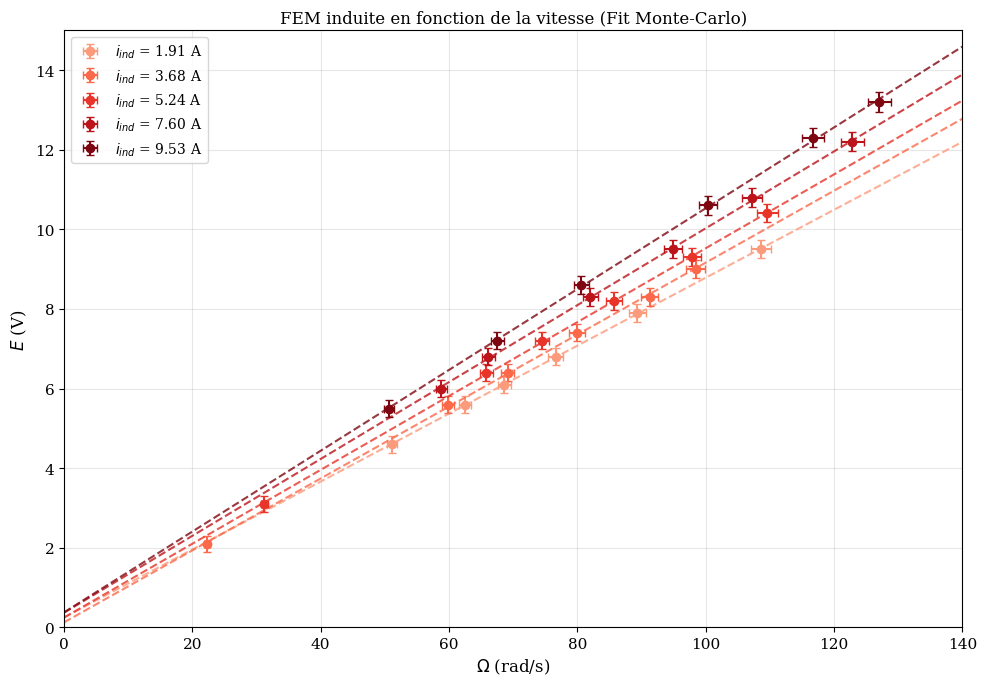

In [290]:
fig1, ax1 = plt.subplots(figsize=(10, 7))
colors = plt.cm.Reds(np.linspace(0.35, 0.95, 5))
markers = ['o', 'o', 'o', 'o', 'o']

mc_results = {} # Stockage pour la figure suivante

print("COMPARAISON DES INCERTITUDES SUR LA PENTE a (V·s/rad)")
print("="*70)
print(f"{'i (A)':<8} {'a (Moyenne MC)':<15} {'u(a) (Reg. Std)':<18} {'u(a) (Monte-Carlo)':<20}")
print("-"*70)

for idx, (I_ind, measurements) in enumerate(data_fem.items()):
    # Préparation des données
    E_vals = np.array([m[0] for m in measurements], dtype=float)
    U_tachy_vals = np.array([m[1] for m in measurements], dtype=float)
    
    omega_vals = convert_to_omega_rad(U_tachy_vals)
    delta_omega = incertitude_omega(U_tachy_vals)
    delta_E = incertitude_tension(E_vals)
    
    # --- 1. Régression Standard (pour comparaison) ---
    res_std = stats.linregress(omega_vals, E_vals)
    u_a_std = res_std.stderr
    
    # --- 2. Monte-Carlo ---
    # Modèle a*x + b
    p_mean, p_std, p_list = monte_carlo_fit(modele_lineaire, 
                                            omega_vals, E_vals, 
                                            delta_omega, delta_E, 
                                            N=1000)
    
    a_mc, b_mc = p_mean
    ua_mc, ub_mc = p_std
    
    # Stockage
    mc_results[I_ind] = {
        'a': a_mc, 'ua': ua_mc,
        'b': b_mc, 'ub': ub_mc
    }
    
    print(f"{I_ind:<8.2f} {a_mc:<15.4f} {u_a_std:<18.4f} {ua_mc:<20.4f}")

    # --- Tracé ---
    # Points expérimentaux avec barres d'erreur
    ax1.errorbar(omega_vals, E_vals, xerr=delta_omega, yerr=delta_E,
                 fmt=markers[idx], color=colors[idx], capsize=3, markersize=6,
                 label=f'$i_{{ind}}$ = {I_ind:.2f} A')
    
    # Droite ajustée (Moyenne MC)
    omega_fit = np.linspace(0, 140, 100)
    E_fit = modele_lineaire(omega_fit, a_mc, b_mc)
    ax1.plot(omega_fit, E_fit, '--', color=colors[idx], alpha=0.8, linewidth=1.5)

ax1.set_xlabel(r'$\Omega$ (rad/s)', fontsize=12)
ax1.set_ylabel(r'$E$ (V)', fontsize=12)
ax1.set_title('FEM induite en fonction de la vitesse (Fit Monte-Carlo)', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 140)
ax1.set_ylim(0, 15)
plt.tight_layout()
plt.savefig('figures/figure1_E_omega.png', dpi=300)
plt.show()

## 4. Figure 2 : k(i_inducteur) avec zone de confiance MC

On trace $k=a$ en fonction de $i_{ind}$. On utilise les incertitudes issues de l'étape précédente.

RÉGRESSION k(i) : k = α·I + β
α = 0.00200 ± 0.00048 (V·s/rad)/A (intervalle 95%)
β = 0.08210 ± 0.00300 V·s/rad (intervalle 95%)


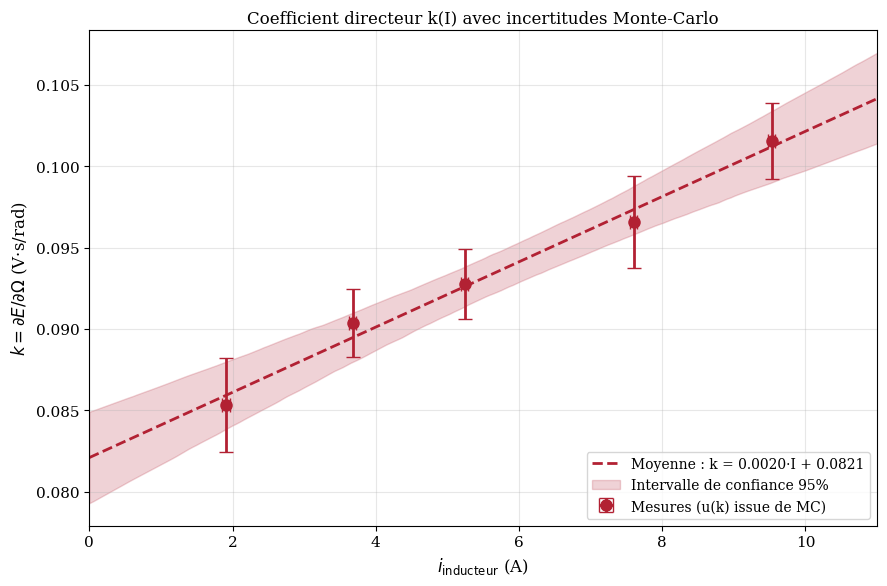

In [291]:
fig2, ax2 = plt.subplots(figsize=(9, 6))

I_vals = np.array(list(mc_results.keys()), dtype=float)
k_vals = np.array([mc_results[I]['a'] for I in I_vals], dtype=float)
uk_vals = np.array([mc_results[I]['ua'] for I in I_vals], dtype=float)

# Incertitude sur I_ind négligée ou très faible par rapport à k, on met une petite valeur pour MC
delta_I = np.ones_like(I_vals) * 0.05 # 50mA incertitude estimée lecture/fluctuation

# --- Monte-Carlo Fit sur k(I) ---
p_mean_k, p_std_k, p_list_k = monte_carlo_fit(modele_lineaire, 
                                              I_vals, k_vals, 
                                              delta_I, uk_vals, 
                                              N=1000)

alpha, beta = p_mean_k
u_alpha, u_beta = p_std_k

# --- Affichage ---
print("RÉGRESSION k(i) : k = α·I + β")
print(f"α = {alpha:.5f} ± {2*u_alpha:.5f} (V·s/rad)/A (intervalle 95%)")
print(f"β = {beta:.5f} ± {2*u_beta:.5f} V·s/rad (intervalle 95%)")

# Tracé des points
ax2.errorbar(I_vals, k_vals, xerr=delta_I, yerr=uk_vals,
             fmt='o', color=ROUGE, capsize=5, markersize=8, linewidth=2,
             label='Mesures (u(k) issue de MC)', zorder=5)

# Tracé du fit moyen
I_fit = np.linspace(0, 11, 200)
k_fit = modele_lineaire(I_fit, alpha, beta)
ax2.plot(I_fit, k_fit, color=ROUGE, linestyle='--', linewidth=2,
         label=f"Moyenne : k = {alpha:.4f}·I + {beta:.4f}")

# Tracé de la bande de confiance 95% (percentile méthode)
k_low, k_high = get_confidence_interval(modele_lineaire, I_fit, p_list_k, percentile=95)
ax2.fill_between(I_fit, k_low, k_high, color=ROUGE, alpha=0.2, label='Intervalle de confiance 95%')

ax2.set_xlabel(r'$i_{\mathrm{inducteur}}$ (A)', fontsize=12)
ax2.set_ylabel(r'$k = \partial E / \partial \Omega$ (V·s/rad)', fontsize=12)
ax2.set_title("Coefficient directeur k(I) avec incertitudes Monte-Carlo", fontsize=12)
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 11)
plt.tight_layout()
plt.savefig('figures/figure2_k_I.png', dpi=300)
plt.show()

## 5. Rendement : Modèle polynomial avec Monte-Carlo

MODÈLE POLYNOMIAL η(P) = c2·P² + c1·P + c0
c2 = -0.000786 ± 0.000818 %/W² (95%)
c1 = 0.3895 ± 0.1590 %/W (95%)
c0 = 1.02 ± 7.20 % (95%)


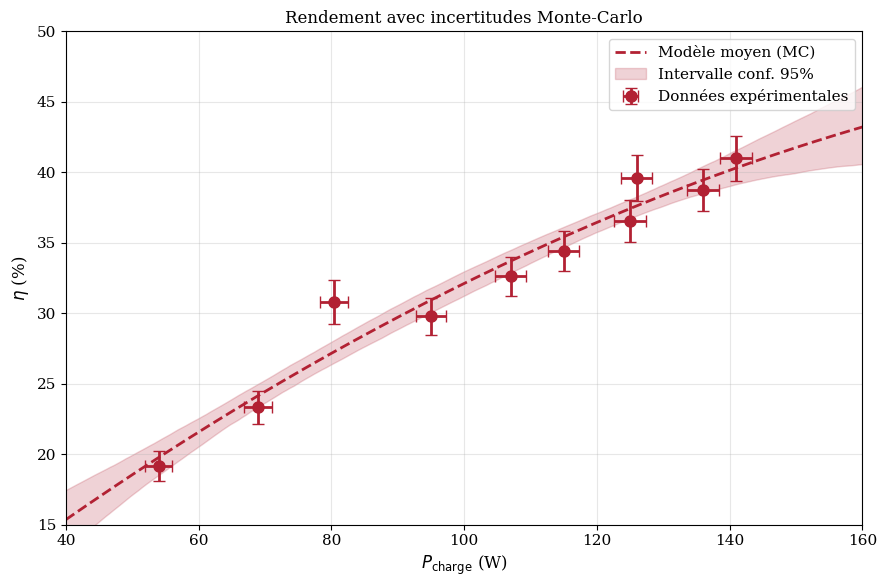

In [292]:
# Données
P_abs = np.array([245.3, 302.3, 328, 335, 326, 318, 312, 303, 280, 266], dtype=float)
P_induc = 16.0
P_charge = np.array([80.4, 126, 141, 136, 125, 115, 107, 95, 69, 54], dtype=float)

# Incertitudes (Constructeur)
delta_P_abs = incertitude_puissance_pince(P_abs)
delta_P_charge = incertitude_puissance_wattmetre(P_charge)
delta_P_induc = incertitude_puissance_wattmetre(P_induc)

# Calcul Rendement et propagation simple pour les points
P_tot = P_abs + P_induc
delta_P_tot = np.sqrt(delta_P_abs**2 + delta_P_induc**2)
eta = P_charge / P_tot * 100
delta_eta_rel = np.sqrt((delta_P_charge / P_charge)**2 + (delta_P_tot / P_tot)**2)
delta_eta = eta * delta_eta_rel

# --- Monte-Carlo Fit Polynomial ---
p_mean_eta, p_std_eta, p_list_eta = monte_carlo_fit(modele_poly2,
                                                    P_charge, eta,
                                                    delta_P_charge, delta_eta,
                                                    N=1000)

c2, c1, c0 = p_mean_eta
uc2, uc1, uc0 = p_std_eta

print("MODÈLE POLYNOMIAL η(P) = c2·P² + c1·P + c0")
print("="*60)
print(f"c2 = {c2:.6f} ± {2*uc2:.6f} %/W² (95%)")
print(f"c1 = {c1:.4f} ± {2*uc1:.4f} %/W (95%)")
print(f"c0 = {c0:.2f} ± {2*uc0:.2f} % (95%)")

# --- Figure 3 ---
fig3, ax3 = plt.subplots(figsize=(9, 6))

# Points
ax3.errorbar(P_charge, eta, xerr=delta_P_charge, yerr=delta_eta,
             fmt='o', color=ROUGE, capsize=4, markersize=8, linewidth=2,
             label='Données expérimentales', zorder=5)

# Modèle moyen
P_fit = np.linspace(40, 160, 200)
eta_fit = modele_poly2(P_fit, c2, c1, c0)
ax3.plot(P_fit, eta_fit, '--', color=ROUGE, linewidth=2, label='Modèle moyen (MC)')

# Zone de confiance 95%
eta_low, eta_high = get_confidence_interval(modele_poly2, P_fit, p_list_eta, percentile=95)
ax3.fill_between(P_fit, eta_low, eta_high, color=ROUGE, alpha=0.2, label='Intervalle conf. 95%')

# Optimum sur courbe moyenne
P_opt = -c1 / (2 * c2)
eta_max = modele_poly2(P_opt, c2, c1, c0)
ax3.axvline(x=P_opt, color='gray', linestyle=':', alpha=0.8)
ax3.annotate(f"P_opt = {P_opt:.0f} W\nη_max = {eta_max:.1f} %",
             xy=(P_opt+2, 25), color='#444')

ax3.set_xlabel(r'$P_{\mathrm{charge}}$ (W)', fontsize=12)
ax3.set_ylabel(r'$\eta$ (%)', fontsize=12)
ax3.set_title('Rendement avec incertitudes Monte-Carlo', fontsize=12)
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(40, 160)
ax3.set_ylim(15, 50)
plt.tight_layout()
plt.savefig('figures/figure3_rendement.png', dpi=300)
plt.show()

## 6. Figure 4 : Rémanence (i_ind = 0)

RÉMANENCE (i=0)
a = 0.2060 ± 0.0262 V·s/rad (95%)
b = 38.96 ± 2.71 V (95%)


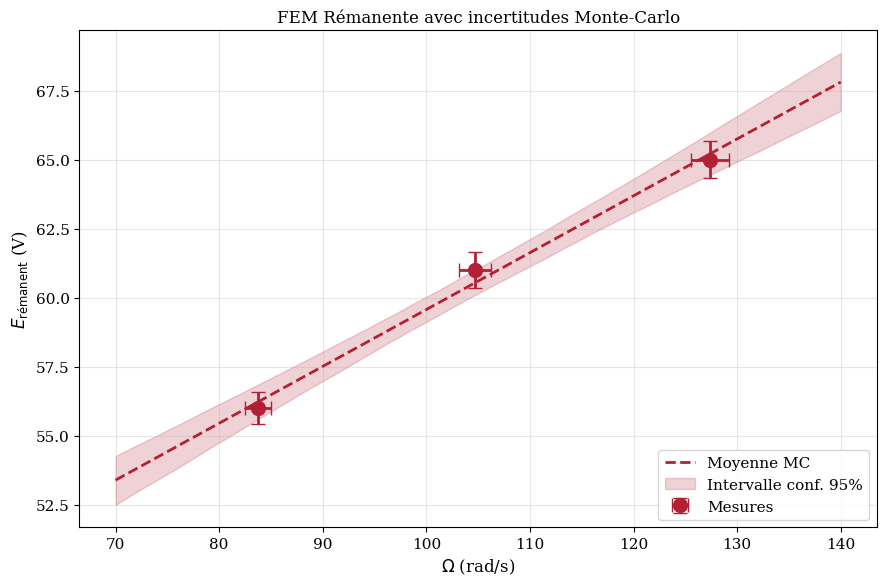

In [293]:
U_tachy_rem = np.array([48, 60, 73], dtype=float)
E_rem = np.array([56, 61, 65], dtype=float)

omega_rem = convert_to_omega_rad(U_tachy_rem)
delta_omega_rem = incertitude_omega(U_tachy_rem)
delta_E_rem = incertitude_tension(E_rem)

# --- Monte-Carlo Fit ---
p_mean_rem, p_std_rem, p_list_rem = monte_carlo_fit(modele_lineaire, 
                                                    omega_rem, E_rem, 
                                                    delta_omega_rem, delta_E_rem, 
                                                    N=1000)
a_rem, b_rem = p_mean_rem
ua_rem, ub_rem = p_std_rem

print("RÉMANENCE (i=0)")
print(f"a = {a_rem:.4f} ± {2*ua_rem:.4f} V·s/rad (95%)")
print(f"b = {b_rem:.2f} ± {2*ub_rem:.2f} V (95%)")

# --- Figure 4 ---
fig4, ax4 = plt.subplots(figsize=(9, 6))

ax4.errorbar(omega_rem, E_rem, xerr=delta_omega_rem, yerr=delta_E_rem,
             fmt='o', color=ROUGE, capsize=5, markersize=10, linewidth=2,
             label='Mesures', zorder=5)

omega_fit_rem = np.linspace(70, 140, 100)
E_fit_rem = modele_lineaire(omega_fit_rem, a_rem, b_rem)
ax4.plot(omega_fit_rem, E_fit_rem, '--', color=ROUGE, linewidth=2, label='Moyenne MC')

rem_low, rem_high = get_confidence_interval(modele_lineaire, omega_fit_rem, p_list_rem, percentile=95)
ax4.fill_between(omega_fit_rem, rem_low, rem_high, color=ROUGE, alpha=0.2, label='Intervalle conf. 95%')

ax4.set_xlabel(r'$\Omega$ (rad/s)', fontsize=12)
ax4.set_ylabel(r'$E_{\mathrm{rémanent}}$ (V)', fontsize=12)
ax4.set_title("FEM Rémanente avec incertitudes Monte-Carlo", fontsize=12)
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/figure4_remanence.png', dpi=300)
plt.show()

## 7. Résumé Final

In [294]:
print("="*80)
print("RÉSUMÉ FINAL AVEC INCERTITUDES MONTE-CARLO (95% = 2*sigma)")
print("="*80)
print("1) Coefficients k(i) :")
for I, res in mc_results.items():
    print(f"  i={I:.2f}A : a = {res['a']:.4f} ± {2*res['ua']:.4f} V·s/rad")

print("\n2) Relation k = alpha*I + beta :")
print(f"  alpha = {alpha:.5f} ± {2*u_alpha:.5f} (V·s/rad)/A")
print(f"  beta  = {beta:.5f} ± {2*u_beta:.5f} V·s/rad")

print("\n3) Rendement Max (Modèle) :")
print(f"  P_opt = {P_opt:.1f} W")
print(f"  eta_max = {eta_max:.2f} %")
print("  (Incertitude modèle complexe, voir bande de confiance sur graphe)")

print("\n4) Rémanence :")
print(f"  b (offset) = {b_rem:.2f} ± {2*ub_rem:.2f} V")
print("="*80)

RÉSUMÉ FINAL AVEC INCERTITUDES MONTE-CARLO (95% = 2*sigma)
1) Coefficients k(i) :
  i=1.91A : a = 0.0853 ± 0.0058 V·s/rad
  i=3.68A : a = 0.0904 ± 0.0042 V·s/rad
  i=5.24A : a = 0.0928 ± 0.0043 V·s/rad
  i=7.60A : a = 0.0966 ± 0.0056 V·s/rad
  i=9.53A : a = 0.1015 ± 0.0047 V·s/rad

2) Relation k = alpha*I + beta :
  alpha = 0.00200 ± 0.00048 (V·s/rad)/A
  beta  = 0.08210 ± 0.00300 V·s/rad

3) Rendement Max (Modèle) :
  P_opt = 247.7 W
  eta_max = 49.26 %
  (Incertitude modèle complexe, voir bande de confiance sur graphe)

4) Rémanence :
  b (offset) = 38.96 ± 2.71 V
